# DLthon - 길찾는 오리들
## Base Settings

In [1]:
# importing the libraries
import keras, tensorflow as tf
from keras import layers

# keras.mixed_precision.set_global_policy('mixed_float16')

# importing the modules
import models_base, models_top, utils

2025-01-20 16:00:44.003103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 16:00:44.012959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737356444.024323  344401 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737356444.028000  344401 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 16:00:44.042535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
# loading the dataset
train_dataset, val_dataset, test_dataset = utils.load_datasets("data_no_aug")

Found 319 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
Found 40 files belonging to 6 classes.


## Basemodel

여기에 ResNet50 결과 입력

## EfficientNetV2L + simple2
### Designing the Model

In [5]:
# designing the model

def eV2L_simple2(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs)
    x = models_base.EV2L((224, 224, 3))(x, training=False)
    x = models_top.simple2()(x)
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
                   metrics=['accuracy'])
    
    return model

eV2L_simple2().summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_preprocessing_v1          │ (None, 224, 224, 3)    │             7 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_simple2 (Sequential)      │ (None, 256)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,142,125 (450.68 MB)

 Trainable params: 395,270 (1.51 MB)

 Non-trainable params: 117,746,855 (449.17 MB)

Epoch 1/200


I0000 00:00:1737356495.401517  344527 cuda_dnn.cc:529] Loaded cuDNN version 90600


5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.1997 - loss: 1.8018 - val_accuracy: 0.3333 - val_loss: 1.7708
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step - accuracy: 0.2102 - loss: 1.7742 - val_accuracy: 0.4103 - val_loss: 1.7568
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.3063 - loss: 1.7426 - val_accuracy: 0.3590 - val_loss: 1.7459
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.2783 - loss: 1.7301 - val_accuracy: 0.3590 - val_loss: 1.7349
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.3223 - loss: 1.7158 - val_accuracy: 0.3590 - val_loss: 1.7228
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.2614 - loss: 1.7147 - val_accuracy: 0.3590 - val_loss: 1.7112
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - accuracy: 0.3765 - loss: 1.6830 - val_accuracy: 0.4359 - val_loss: 1.6993
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.3564 - loss: 1.6895 - val_accuracy: 0.4103 - val_loss: 1.683

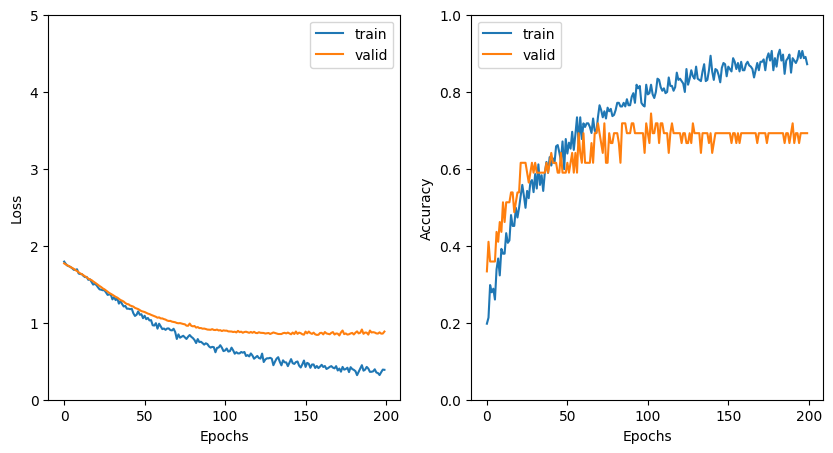

In [6]:
eV2L_simple2_history = eV2L_simple2().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_simple2.keras'),
        utils.callback_earlystop(30)
    ],
)
utils.plot_history(eV2L_simple2_history)

In [7]:
test_loss, test_acc = keras.models.load_model('eV2L_simple2.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8250 - loss: 0.6606
Test accuracy: 0.82%, Test loss: 0.66


In [8]:
# designing the model

def eV2L_midsize1(): # this can be adjusted to be hyper-tunable
    inputs = keras.Input(shape=(224, 224, 3))
    x = utils.image_preprocessing_v1()(inputs)
    x = models_base.EV2L((224, 224, 3))(x, training=False)
    x = models_top.midsize1()(x)
    outputs = layers.Dense(6, activation='softmax', name="classifier")(x)

    model = keras.Model(inputs, outputs)
    
    model.compile(loss='categorical_crossentropy',
                   optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                   metrics=['accuracy'])
    
    return model

eV2L_midsize1().summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_preprocessing_v2          │ (None, 224, 224, 3)    │            12 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ basic_midsize1 (Sequential)     │ (None, 256)            │     1,049,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,798,258 (453.18 MB)

 Trainable params: 1,051,404 (4.01 MB)

 Non-trainable params: 117,746,854 (449.17 MB)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2126 - loss: 1.7959 - val_accuracy: 0.1795 - val_loss: 1.7769
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 749ms/step - accuracy: 0.2104 - loss: 1.7863 - val_accuracy: 0.2564 - val_loss: 1.7637
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.2257 - loss: 1.7828 - val_accuracy: 0.0769 - val_loss: 1.7752
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.2170 - loss: 1.7688 - val_accuracy: 0.1795 - val_loss: 1.7686
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.1979 - loss: 1.7826 - val_accuracy: 0.2564 - val_loss: 1.7821
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.2036 - loss: 1.7527 - val_accuracy: 0.1282 - val_loss: 1.7320
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.2681 - loss: 1.7484 - val_accuracy: 0.2564 - val_loss: 1.6960
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.2535 - loss: 1.7097 - val_accura

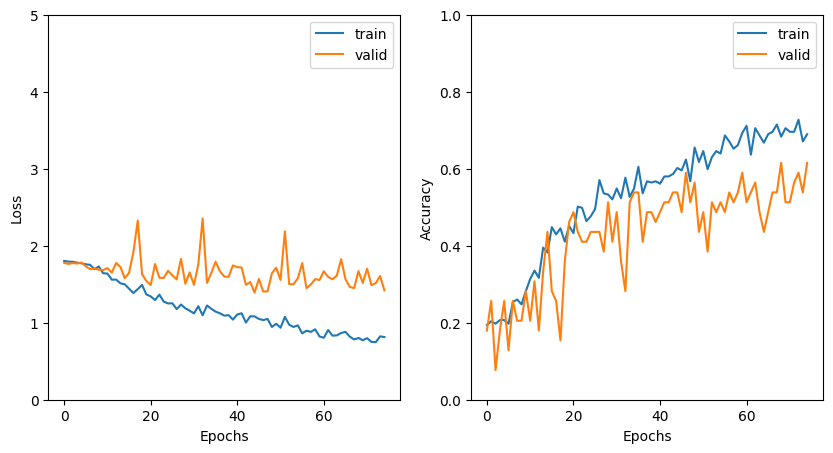

In [14]:
eV2L_midsize1_history = eV2L_midsize1().fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[
        utils.callback_savemodel('eV2L_midsize1.keras'),
        utils.callback_earlystop(30)
    ],
)

utils.plot_history(eV2L_midsize1_history)

In [15]:
test_loss, test_acc = keras.models.load_model('eV2L_midsize1.keras').evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.2f}%, Test loss: {test_loss:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.7937 - loss: 0.8148
Test accuracy: 0.80%, Test loss: 0.78
